In [4]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
from scipy.signal import czt
from scipy.optimize import least_squares
from scipy.signal import spectrogram
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def readCsv(pathFile):
    arrays = []
    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [6]:
file_path = './FMCW Radar/Rawdata/Rawdata_2.csv'
raw_data = readCsv(file_path)
raw_data_channel_0 = raw_data[0]

In [7]:
T_c = 91.72 * (1e-6)   # Chirp time
NUM_SAMPLE_CHIRP = 256
SAMPLING_RATE = 3000000
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
RANGE_RESOLUTION=0.04 # 4cm
MAX_RANGE=11#11 m = 1100 cm
c = 299792458

In [8]:
d_res = c/(2*B)
slope = B/T_c 
print("range resolution {0} mm".format(d_res*1000))
print("slope {0}".format(slope))


range resolution 39.97232773333333 mm
slope 40885303096380.29


In [9]:
chirps = [raw_data_channel_0[i:i+NUM_SAMPLE_CHIRP] for i in range(0, len(raw_data_channel_0), NUM_SAMPLE_CHIRP)]
chirps_frame =[chirps[j] for j in range(0, len(chirps), 2)]
print(np.array(chirps_frame).shape)
chirps_frame_shape = np.array(chirps_frame).shape

(6000, 256)


In [10]:
NFFT=256
range_profile =[np.fft.fft(chirp,NFFT) for chirp in chirps_frame]
range_profile_shape = np.array(range_profile).shape
print(range_profile_shape)

(6000, 256)


In [11]:
range_bin = range_profile_shape[1]
frame_number =range_profile_shape[0]
estimated_background_range_profile = np.zeros(range_bin,dtype=complex)
for bin_index in range (0,range_bin):
    estimated_background_range_profile[bin_index] = np.average(np.array(range_profile)[:,bin_index])
print("background estimation: ",estimated_background_range_profile.shape)

removal_background_range_profile =np.zeros_like(range_profile)
frame_number =range_profile_shape[0]
for  bin_index in range (0,range_bin):
    for frame_index in range(0,frame_number):
        removal_background_range_profile [frame_index][bin_index] = range_profile[frame_index][bin_index] - estimated_background_range_profile[bin_index]
print("background removal range profile: ",removal_background_range_profile.shape)  

background estimation:  (256,)
background removal range profile:  (6000, 256)


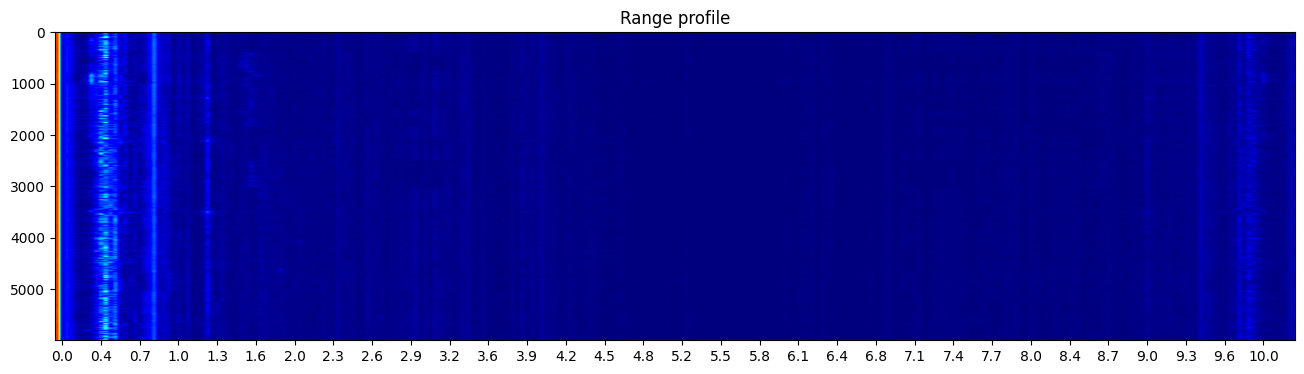

In [12]:
magnitude_range_profile = [np.abs(profile) for profile in range_profile]
rangeBinDistance = [round(j*d_res,1) for j in range(1,NFFT,8) ]
plt.figure(figsize=(16,4))
plt.imshow(magnitude_range_profile,aspect='auto',cmap='jet')
plt.xticks(range(1,NFFT,8), rangeBinDistance)
plt.title("Range profile")
plt.show()

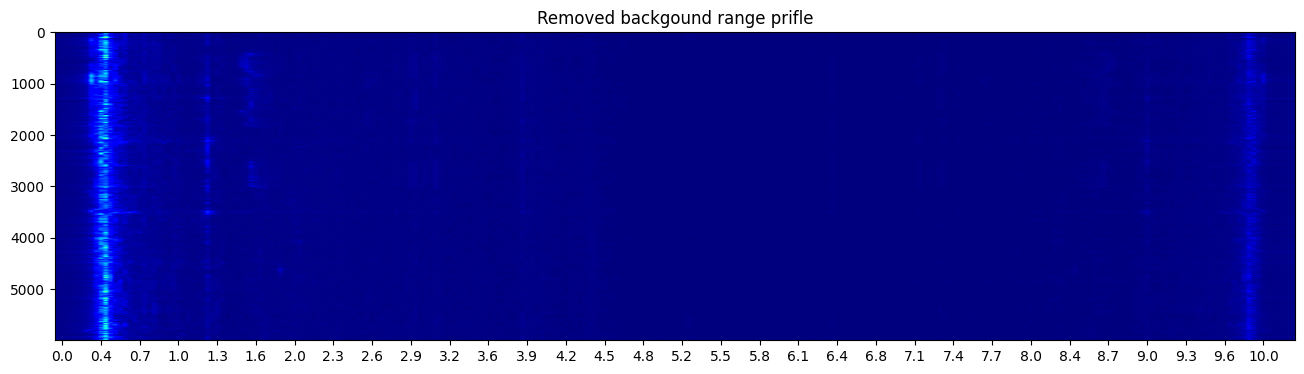

In [13]:
magnitude_removal_background_range_profile =[np.abs(rm_backrange)  for rm_backrange in removal_background_range_profile]
rangeBinDistance = [round(j*d_res,1) for j in range(1,NFFT,8) ]
plt.figure(figsize=(16,4))
plt.imshow(magnitude_removal_background_range_profile,aspect='auto',cmap='jet')
plt.xticks(range(1,NFFT,8), rangeBinDistance)
plt.title("Removed backgound range prifle")
plt.show()

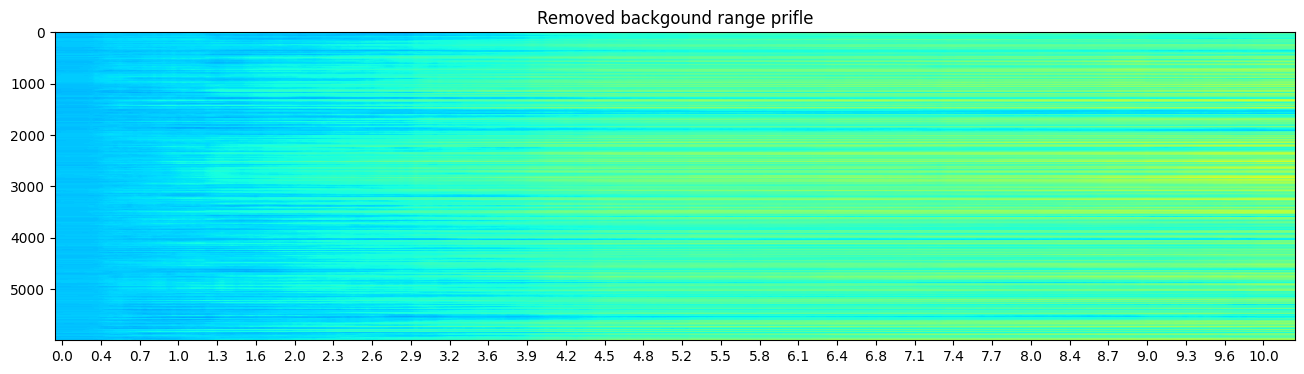

In [42]:


angles =np.angle(removal_background_range_profile)
angles_unwrapped =np.unwrap(angles,1)
    

# magnitude_removal_background_range_profile =[np.abs(rm_backrange)  for rm_backrange in removal_background_range_profile]
rangeBinDistance = [round(j*d_res,1) for j in range(1,NFFT,8) ]
plt.figure(figsize=(16,4))
plt.imshow(angles_unwrapped,aspect='auto',cmap='jet')
plt.xticks(range(1,NFFT,8), rangeBinDistance)
plt.title("Removed backgound range prifle")
plt.show()

(6000, 256)


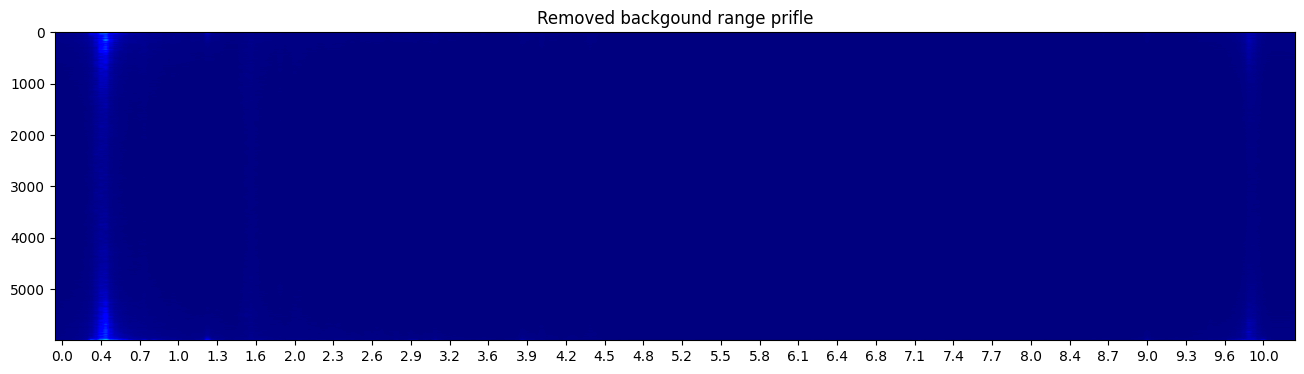

In [45]:
print(np.array(angles_unwrapped).shape)
vibrationMap= np.fft.fft(np.array(removal_background_range_profile), axis=0)

rangeBinDistance = [round(j*d_res,1) for j in range(1,NFFT,8) ]
plt.figure(figsize=(16,4))
plt.imshow(np.abs(vibrationMap),aspect='auto',cmap='jet')
plt.xticks(range(1,NFFT,8), rangeBinDistance)
plt.title("Removed backgound range prifle")
plt.show()

(6000, 256)


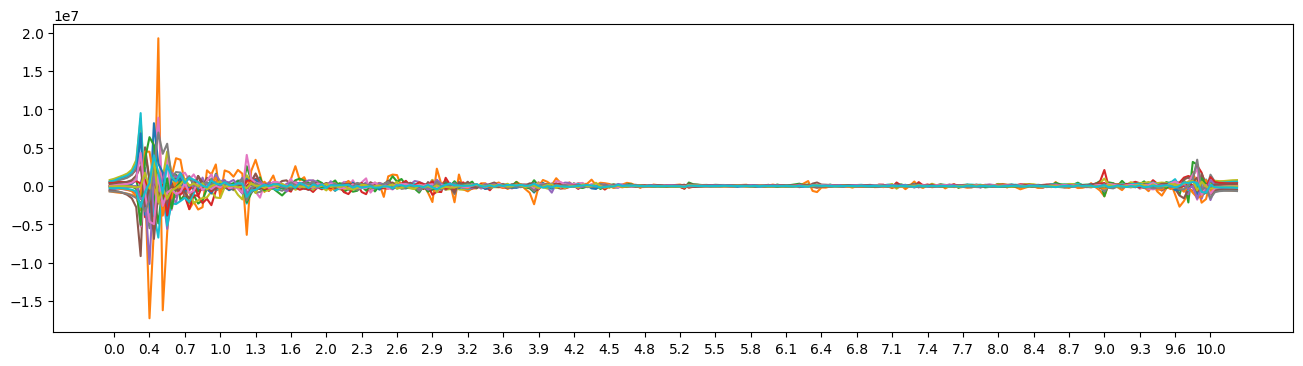

In [57]:

print(np.array(vibrationMap).shape)
rangeBinDistance = [round(j*d_res,1) for j in range(1,NFFT,8) ]
plt.figure(figsize=(16,4))
for i in range(0,20 ):
    plt.plot(vibrationMap[i])

plt.xticks(range(1,NFFT,8), rangeBinDistance)
plt.show()

In [66]:
#range_profile_for_estimation = range_profile
range_profile_for_estimation = removal_background_range_profile


In [67]:
magnitude_range_profile_for_estimation = [np.abs(est_profile) for est_profile in range_profile_for_estimation]
magnitude_range_profile_for_estimation_shape =np.array(magnitude_range_profile_for_estimation).shape
max_indices =[0]*magnitude_range_profile_for_estimation_shape[0]
for mag_profile in magnitude_range_profile_for_estimation:
    max_index = np.argmax(mag_profile)
    max_indices[max_index]+=1
interesting_bin =np.argmax(max_indices)
print(interesting_bin)

10


In [68]:
def extractPhase(interestingRangeBinPhase):
    interestingRangeBinLen =len(interestingRangeBinPhase)
    phaseExtracted = np.zeros(len(interestingRangeBinPhase),dtype=float)
    phaseExtracted[0]=np.angle(interestingRangeBinPhase[0])
    
    for i in range(1,interestingRangeBinLen):        
        tmpPhase =0
        for j in range(1,i):
            I_k=interestingRangeBinPhase[j].real
            Q_k=interestingRangeBinPhase[j].imag
            I_k_prev=interestingRangeBinPhase[j-1].real
            Q_k_prev=interestingRangeBinPhase[j-1].imag
            tmpPhase+= (I_k * (Q_k - Q_k_prev) -(I_k - I_k_prev)* Q_k)/(I_k**2 + Q_k **2)

        phaseExtracted[i]= tmpPhase
    return phaseExtracted

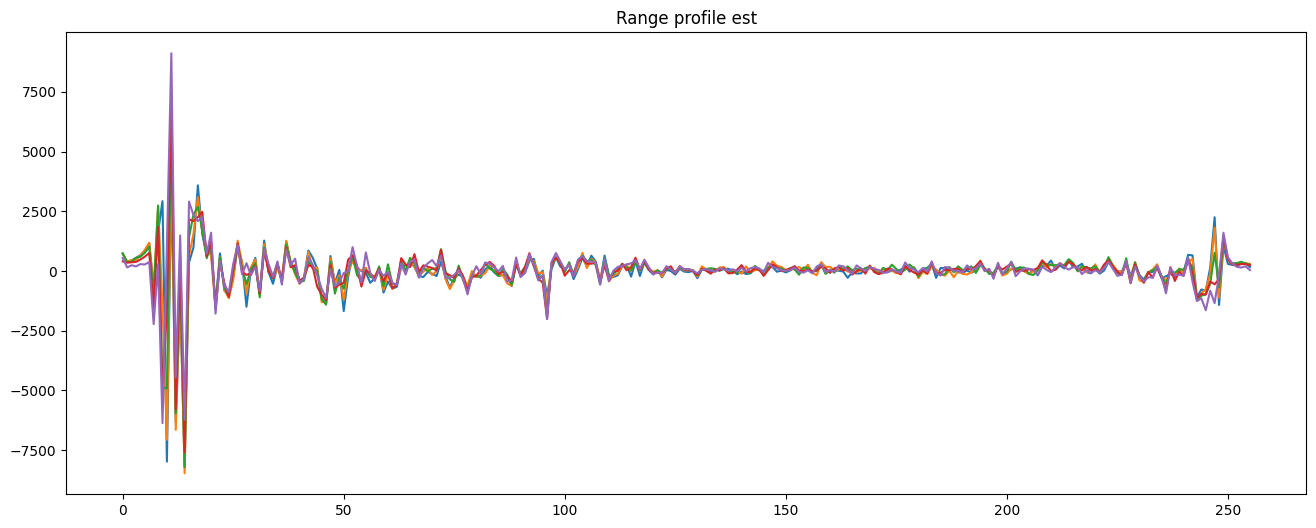

In [69]:
plt.figure(figsize=(16,6))
for i in range(0,5 ):
    plt.plot(range_profile_for_estimation[i])
plt.title("Range profile est")
plt.show()

In [70]:
phase_at_interest_bin = np.array(range_profile_for_estimation)[:,interesting_bin]
# phase_at_interest_bin=phase_at_interest_bin[:1200]
angle_phase_at_interest_bin = np.angle(phase_at_interest_bin)
unwrapped_angle_phase_at_interest_bin = np.unwrap(angle_phase_at_interest_bin)

In [71]:
unwrapped_phase_DACM= extractPhase(phase_at_interest_bin)

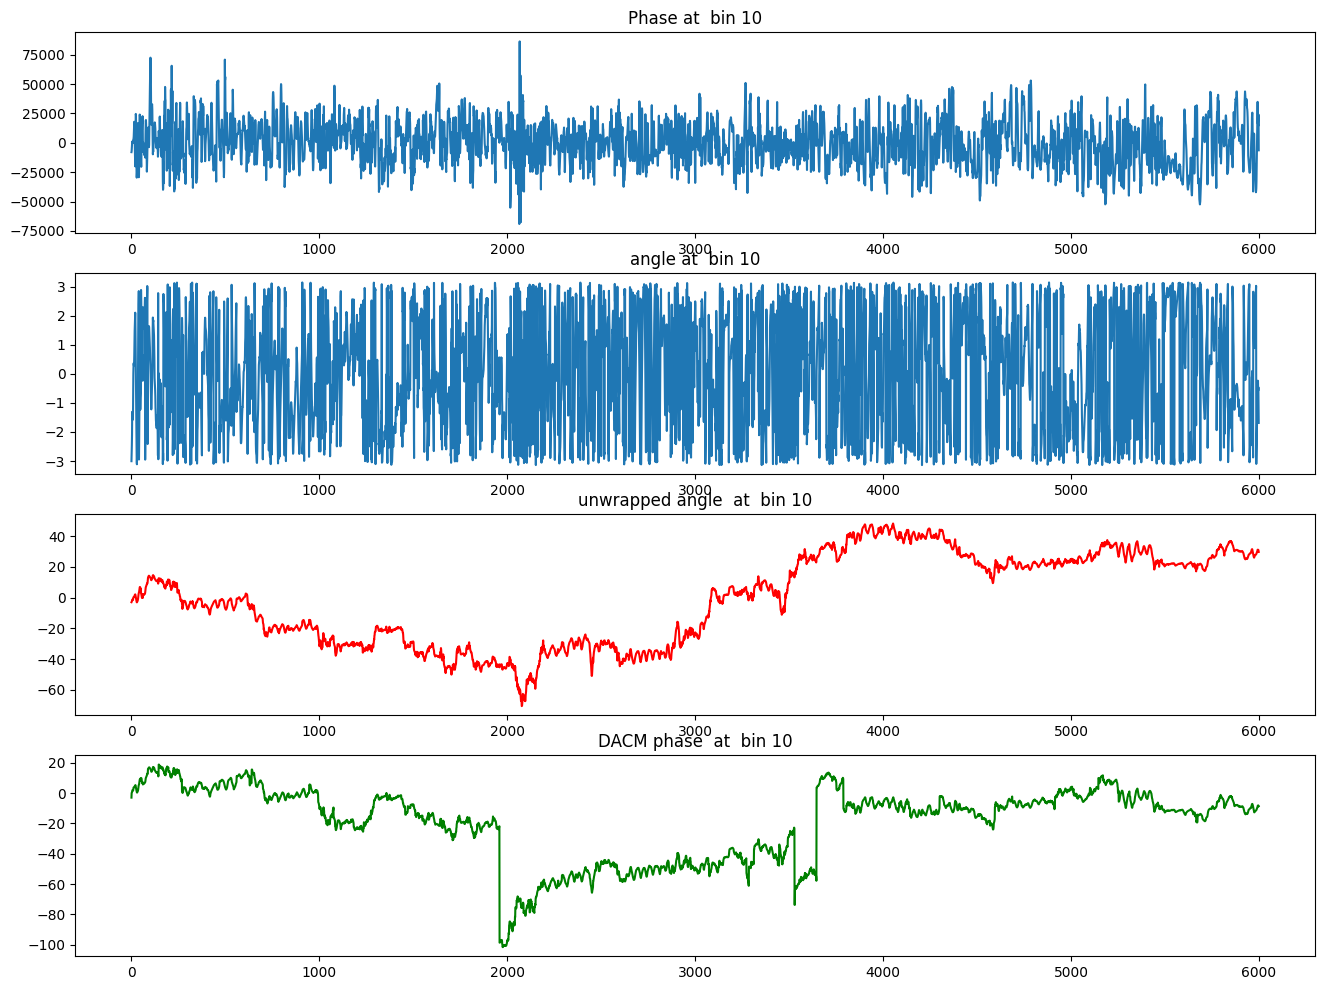

In [72]:
plt.figure(figsize=(16,12))
plt.subplot(411)
plt.plot(phase_at_interest_bin)
plt.title("Phase at  bin {0}".format(interesting_bin))
plt.subplot(412)
plt.plot(angle_phase_at_interest_bin)
plt.title("angle at  bin {0}".format(interesting_bin))
plt.subplot(413)
plt.plot(unwrapped_angle_phase_at_interest_bin,color="red")
plt.title("unwrapped angle  at  bin {0}".format(interesting_bin))


plt.subplot(414)
plt.plot(unwrapped_phase_DACM,color="green")
plt.title("DACM phase  at  bin {0}".format(interesting_bin))
plt.show()

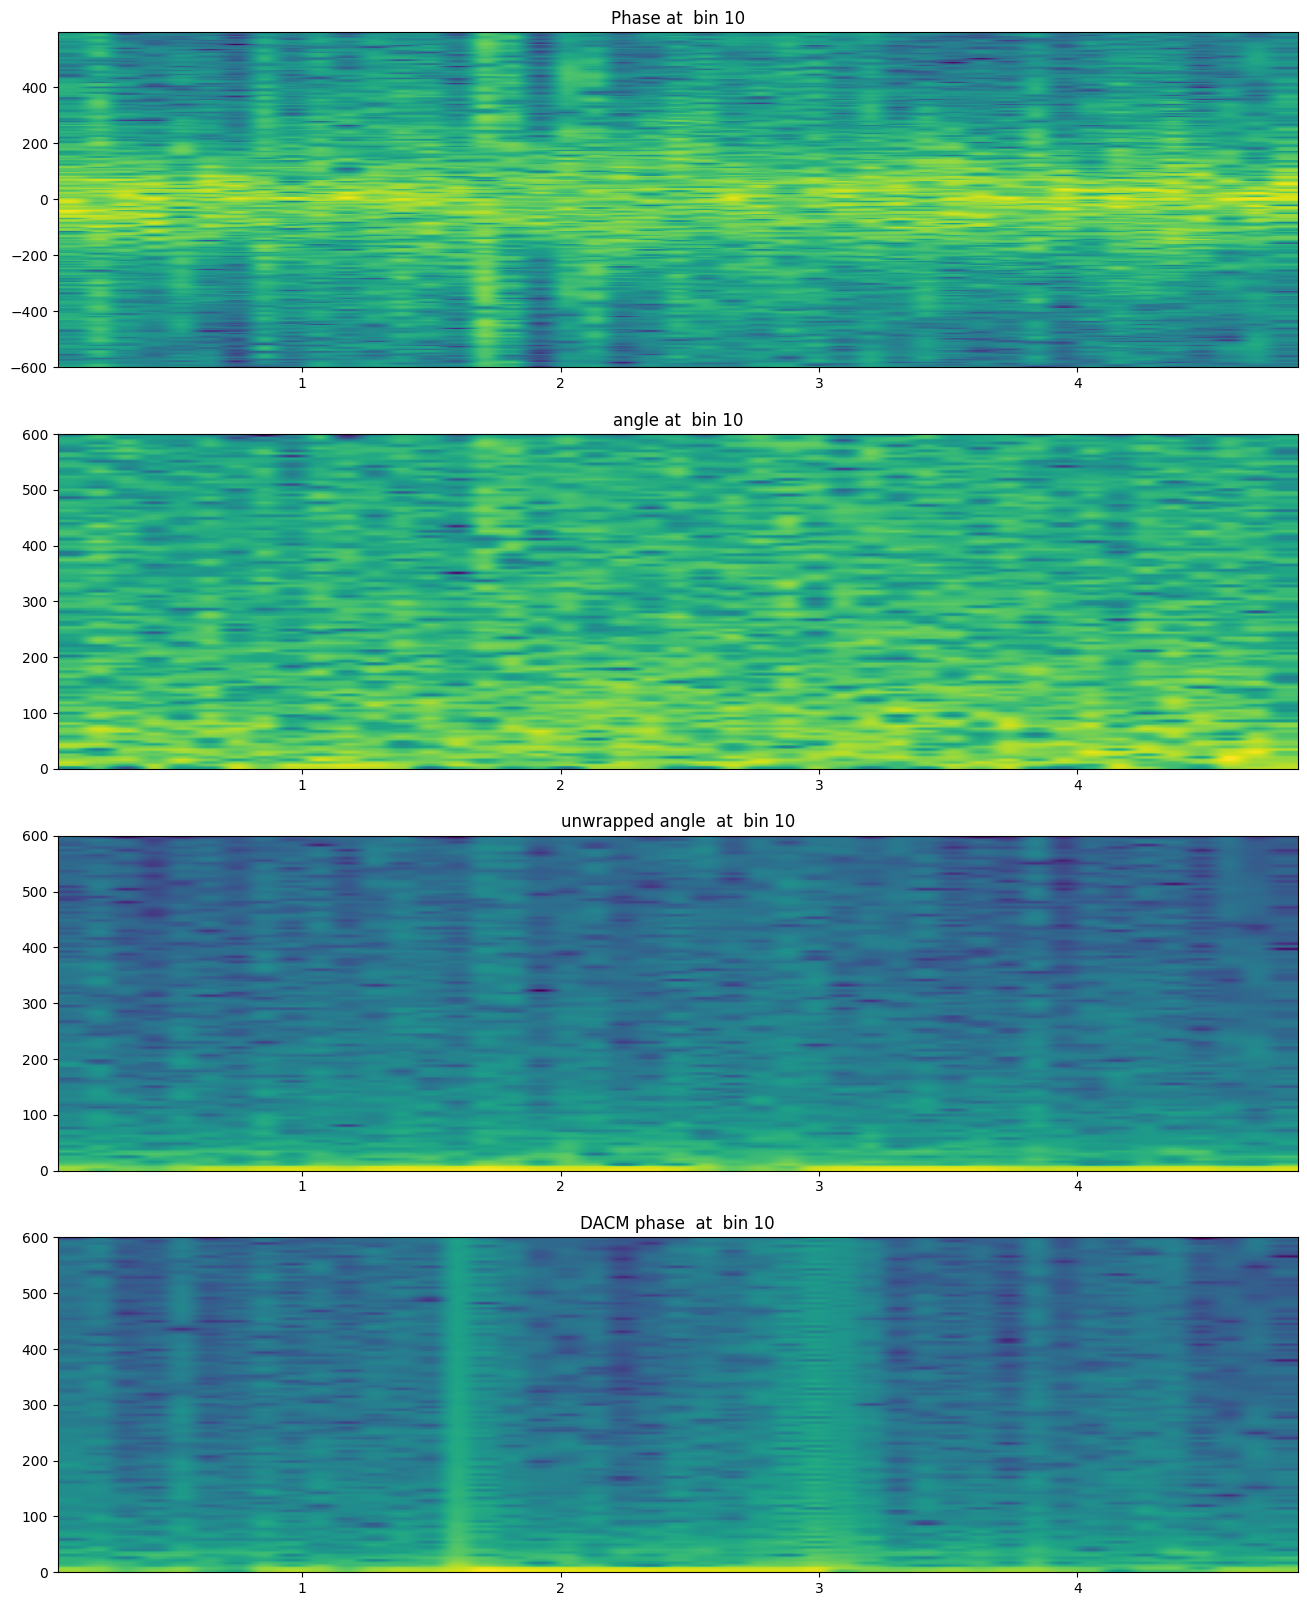

In [73]:
plt.figure(figsize=(16,20))
plt.subplot(411)
plt.specgram(phase_at_interest_bin,Fs=20*60)
plt.title("Phase at  bin {0}".format(interesting_bin))
plt.subplot(412)
plt.specgram(angle_phase_at_interest_bin,Fs=20*60)
plt.title("angle at  bin {0}".format(interesting_bin))
plt.subplot(413)
plt.specgram(unwrapped_angle_phase_at_interest_bin,Fs=20*60)
plt.title("unwrapped angle  at  bin {0}".format(interesting_bin))
plt.subplot(414)
plt.specgram(unwrapped_phase_DACM,Fs=20*60)
plt.title("DACM phase  at  bin {0}".format(interesting_bin))
plt.savefig('my_plot.png')
plt.show()

In [74]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

Text(0.5, 1.0, 'interest_bin_angle_unwrapped')

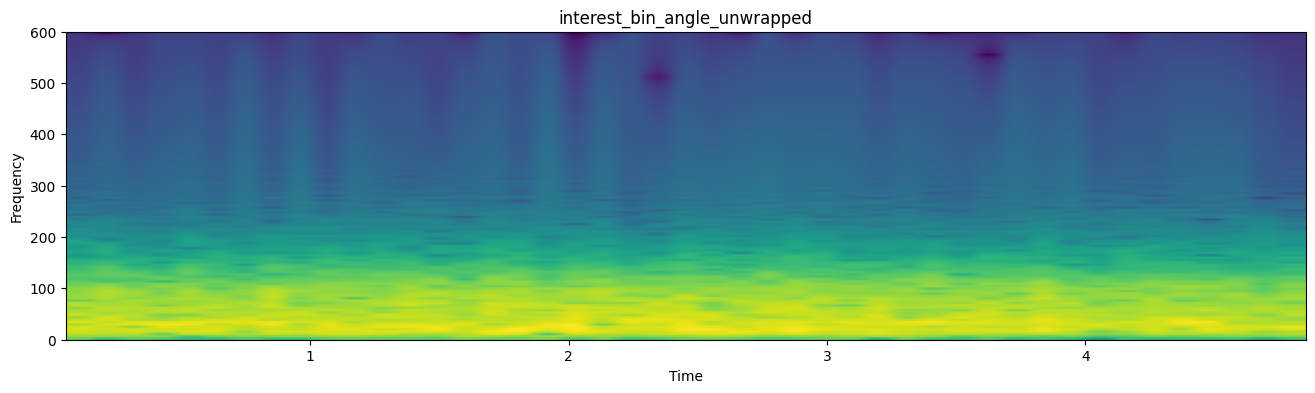

In [75]:
SR=1200/60
breath_heart_band_filtering=[0.2,1.7]
filtered_signal =filter_signal(np.array(unwrapped_angle_phase_at_interest_bin),breath_heart_band_filtering[0],breath_heart_band_filtering[1],SR,4)
plt.figure(figsize=(16,4))
plt.specgram(filtered_signal,Fs=20*60)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('interest_bin_angle_unwrapped')